In [7]:
import ants
from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib

from nilearn import image
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiLabelsMasker

In [2]:
img = ants.image_read('data/2024-04-30_15_15_01.0_AV1451_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_6mm_Res_4.nii.gz')
mni_map = ants.image_read(ants.get_ants_data('mni'))

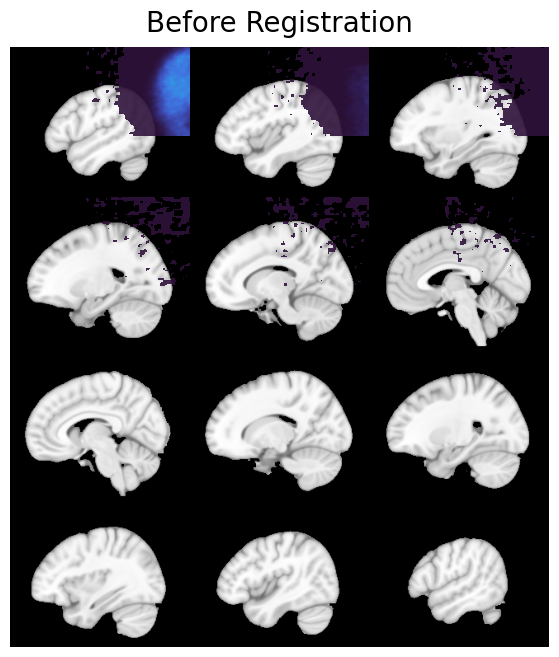

In [3]:
mni_map.plot(overlay=img, title="Before Registration")

{'warpedmovout': ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]
, 'warpedfixout': ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (160, 160, 96)
	 Spacing    : (1.5, 1.5, 1.5)
	 Origin     : (-0.0, 238.5, 1.5)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]
, 'fwdtransforms': ['/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/tmpel_ztrd01Warp.nii.gz', '/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/tmpel_ztrd00GenericAffine.mat'], 'invtransforms': ['/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/tmpel_ztrd00GenericAffine.mat', '/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/tmpel_ztrd01InverseWarp.nii.gz']}


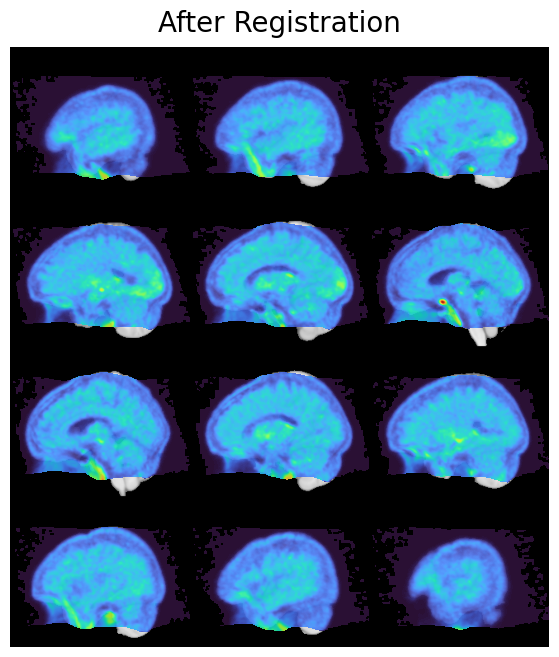

In [51]:
mytx = ants.registration(fixed=mni_map , moving=img, type_of_transform='SyN' )
print(mytx)
warped_moving = mytx['warpedmovout']
mni_map.plot(overlay=warped_moving,
           title='After Registration')

In [52]:
ants.image_write(warped_moving, 'data/av1451_mni.nii.gz')

In [5]:
# Fetch the Schaefer 100 parcellation atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_filename = atlas['maps']

# # Load the PET scan (replace 'path/to/your/pet_scan.nii' with your PET scan file)
# pet_img = nib.load('data/av1451_mni.nii.gz')

# # Load the Schaefer 100 parcellation atlas
# atlas_img = nib.load(atlas_filename)

# # Resample the atlas to the PET scan's resolution
# resampled_atlas_img = resample_to_img(atlas_img, pet_img, interpolation='nearest')

# # Create a masker for the parcellation
# masker = NiftiLabelsMasker(labels_img=resampled_atlas_img, standardize=True)

# # Extract time series data from the PET scan using the masker
# region_signals = masker.fit_transform(pet_img)

# # normalise regional signals:
# region_signals = region_signals / np.sum(region_signals)

# # # Save the extracted region signals to a CSV file
# np.savetxt('../../data/adni/PET/csv/region_signals.csv', region_signals, delimiter=',')

Visualise Parcelated Abeta and Tau Images:

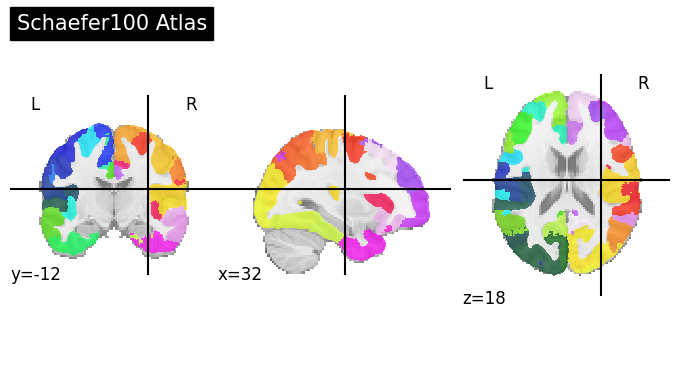

In [6]:
from nilearn import plotting

plotting.plot_roi(atlas_filename, title="Schaefer100 Atlas")

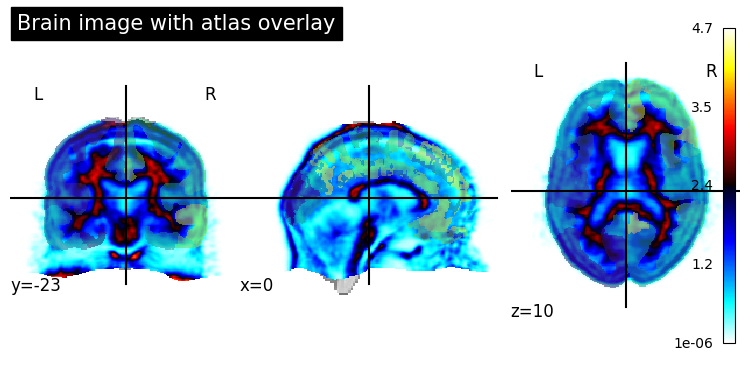

In [12]:
nifti_img = image.load_img(f'../../abeta examples/003_S_4900.nii.gz')

display = plotting.plot_stat_map(nifti_img, title="Brain image with atlas overlay")
display.add_overlay(atlas_filename, alpha=0.5)


## Average AB and Tau parcellations per Patient Group

In [7]:
av45_df = pd.read_csv('data/abeta_tau_data/av45_mni152_5_21_2024.csv')
av45_df = av45_df[(av45_df['Description'] == 'AV45 Coreg, Avg, Std Img and Vox Siz, Uniform 6mm Res')]
print(av45_df['Group'].value_counts())

av1451_df = pd.read_csv('data/abeta_tau_data/av1451_mni152_5_21_2024.csv')
av1451_df = av1451_df[(av1451_df['Description'] == 'AV1451 Coreg, Avg, Std Img and Vox Siz, Uniform 6mm Res')]
print(av1451_df['Group'].value_counts())

Group
CN     33
MCI    17
AD      8
SMC     2
Name: count, dtype: int64
Group
CN     42
MCI    23
AD      9
Name: count, dtype: int64


In [8]:
INPUT_DIR = '../../data/adni/PET/csv'
OUTPUT_DIR = 'data/abeta_tau_data/avg_scans'

In [ ]:
patient_groups = ['CN', 'MCI', 'AD']

for group in patient_groups:
    av45_df_sub = av45_df[(av45_df['Group'] == group)]

    ab_scans = []
    for subj in av45_df_sub['Subject']:
        arr = np.genfromtxt(f'{INPUT_DIR}/AB_{subj}.csv', delimiter=",")
        ab_scans.append(arr)
    
    print(f'GROUP: {group}, no. of AB scans: {len(ab_scans)}')

    stack_ab_scans = np.stack(ab_scans)
    average_ab_scans = np.mean(stack_ab_scans, axis=0)
    average_ab_scans = average_ab_scans.reshape(1, -1)
    np.savetxt(f'{OUTPUT_DIR}/AB_{group}.csv', average_ab_scans, delimiter=",")

    # A-Beta
    av1451_df_sub = av1451_df[(av1451_df['Group'] == group)]

    tau_scans = []
    for subj in av1451_df_sub['Subject']:
        arr = np.genfromtxt(f'{INPUT_DIR}/TAU_{subj}.csv', delimiter=',')
        tau_scans.append(arr)

    print(f'GROUP: {group}, no. of Tau scans: {len(tau_scans)}')

    stack_tau_scans = np.stack(tau_scans)
    average_tau_scans = np.mean(stack_tau_scans, axis=0)
    average_tau_scans = average_tau_scans.reshape(1, -1)
    np.savetxt(f'{OUTPUT_DIR}/TAU_{group}.csv', average_tau_scans, delimiter=',')
    # print(len(average_tau_scans))